In [3]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'allsides_balanced_news_headlines-texts.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,Unnamed: 0,title,tags,heading,source,text,bias_rating
0,0,Gun Violence Over Fourth of July Weekend,"['Protests', 'Fourth Of July', 'Gun Control An...",Chicago Gun Violence Spikes and Increasingly F...,New York Times (News),As Yasmin Miller drove home from a laundromat ...,left
1,1,Gun Violence Over Fourth of July Weekend,"['Protests', 'Fourth Of July', 'Gun Control An...",‘Bullets just came from nowhere’: Fourth of Ju...,Chicago Tribune,As many Chicagoans were celebrating the Fourth...,center
2,2,Gun Violence Over Fourth of July Weekend,"['Protests', 'Fourth Of July', 'Gun Control An...",Dozens of shootings across US mark bloody July...,New York Post (News),The nation’s 4th of July weekend was marred by...,right
3,3,Yellen Warns Congress of 'Economic Recession' ...,"['Janet Yellen', 'Debt Ceiling', 'Economic Pol...",Federal Government Will Run Out of Cash on Oct...,The Epoch Times,Treasury Secretary Janet Yellen on Tuesday war...,right
4,4,Yellen Warns Congress of 'Economic Recession' ...,"['Janet Yellen', 'Debt Ceiling', 'Economic Pol...",Yellen tells Congress that U.S. will run out o...,Washington Post,Treasury Secretary Janet Yellen on Tuesday tol...,left


In [4]:
import re

# Step 1: Clean the text column
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Lowercase text
        text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and digits
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text
    return ""

# Apply cleaning to the 'text' column
data['clean_text'] = data['text'].apply(clean_text)

# Display a sample of the cleaned text
data[['text', 'clean_text']].head()


,text,clean_text
0,As Yasmin Miller drove home from a laundromat ...,as yasmin miller drove home from a laundromat ...
1,As many Chicagoans were celebrating the Fourth...,as many chicagoans were celebrating the fourth...
2,The nation’s 4th of July weekend was marred by...,the nations th of july weekend was marred by t...
3,Treasury Secretary Janet Yellen on Tuesday war...,treasury secretary janet yellen on tuesday war...
4,Treasury Secretary Janet Yellen on Tuesday tol...,treasury secretary janet yellen on tuesday tol...


In [ ]:
# Install spaCy and download the English model
!pip install spacy
!python -m spacy download en_core_web_sm

# Load spaCy's English tokenizer
import spacy
nlp = spacy.load("en_core_web_sm")

# Tokenize using spaCy
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_punct and not token.is_space]

# Apply spaCy tokenizer to clean text
data['spacy_tokens'] = data['clean_text'].apply(spacy_tokenizer)

# Display sample data
data[['clean_text', 'spacy_tokens']].head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 108.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

# Use SpaCy's stopwords
spacy_stopwords = STOP_WORDS

# Remove stopwords using SpaCy
data['filtered_tokens'] = data['spacy_tokens'].apply(lambda x: [word for word in x if word.lower() not in spacy_stopwords])

# Display sample data
data[['spacy_tokens', 'filtered_tokens']].head()


,spacy_tokens,filtered_tokens
0,"[as, yasmin, miller, drove, home, from, a, lau...","[yasmin, miller, drove, home, laundromat, chic..."
1,"[as, many, chicagoans, were, celebrating, the,...","[chicagoans, celebrating, fourth, july, barbec..."
2,"[the, nations, th, of, july, weekend, was, mar...","[nations, th, july, weekend, marred, wrong, ki..."
3,"[treasury, secretary, janet, yellen, on, tuesd...","[treasury, secretary, janet, yellen, tuesday, ..."
4,"[treasury, secretary, janet, yellen, on, tuesd...","[treasury, secretary, janet, yellen, tuesday, ..."


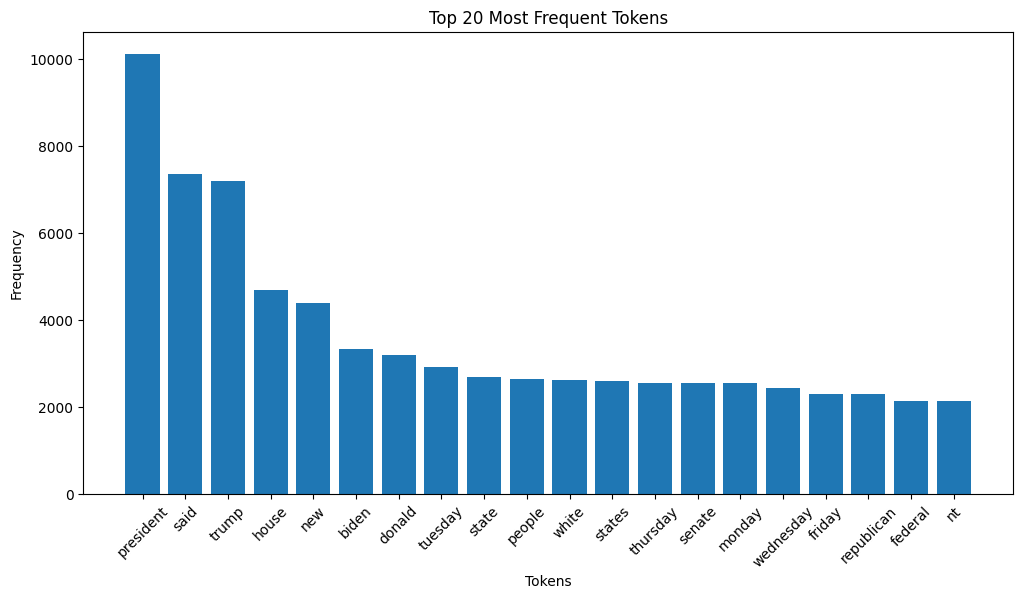

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of tokens
all_tokens = [token for tokens in data['filtered_tokens'] for token in tokens]

# Count token frequencies
token_counts = Counter(all_tokens)
most_common = token_counts.most_common(20)  # Top 20 most frequent tokens

# Prepare data for plotting
tokens, counts = zip(*most_common)

# Plot token frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(tokens, counts)
plt.title("Top 20 Most Frequent Tokens")
plt.ylabel("Frequency")
plt.xlabel("Tokens")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from gensim.models import Word2Vec

# Step 1: Train Word2Vec embeddings on the filtered tokens
word2vec_model = Word2Vec(sentences=data['filtered_tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Step 2: Check the nearest neighbors for the word "gun"
if "gun" in word2vec_model.wv:
    similar_words = word2vec_model.wv.most_similar("gun", topn=10)
else:
    similar_words = "Word 'gun' not found in vocabulary."

similar_words


[('control', 0.7917343974113464),
 ('background', 0.7364085912704468),
 ('kidney', 0.7288398742675781),
 ('morningafter', 0.7109244465827942),
 ('violence', 0.7077151536941528),
 ('birth', 0.7044692039489746),
 ('spiraled', 0.6951629519462585),
 ('checks', 0.6906768679618835),
 ('centers', 0.6831082105636597),
 ('enshrining', 0.6729769706726074)]

In [ ]:
# --- Step 1: Prepare Data ---
MAX_VOCAB_SIZE = 10000  # Max vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Max length for padding
EMBEDDING_DIM = 100  # Embedding size

# Flatten filtered tokens into sentences
data['filtered_text'] = data['filtered_tokens'].apply(lambda x: ' '.join(x))

# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data['filtered_text'])
sequences = tokenizer.texts_to_sequences(data['filtered_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Encode labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}
data = data[data['bias_rating'].isin(label_mapping)]  # Filter valid bias ratings
y = data['bias_rating'].map(label_mapping).values
y = to_categorical(y, num_classes=3)  # One-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 2: Define the Model ---
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Step 3: Train the Model ---
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# --- Step 4: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

KeyError: 'filtered_tokens'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


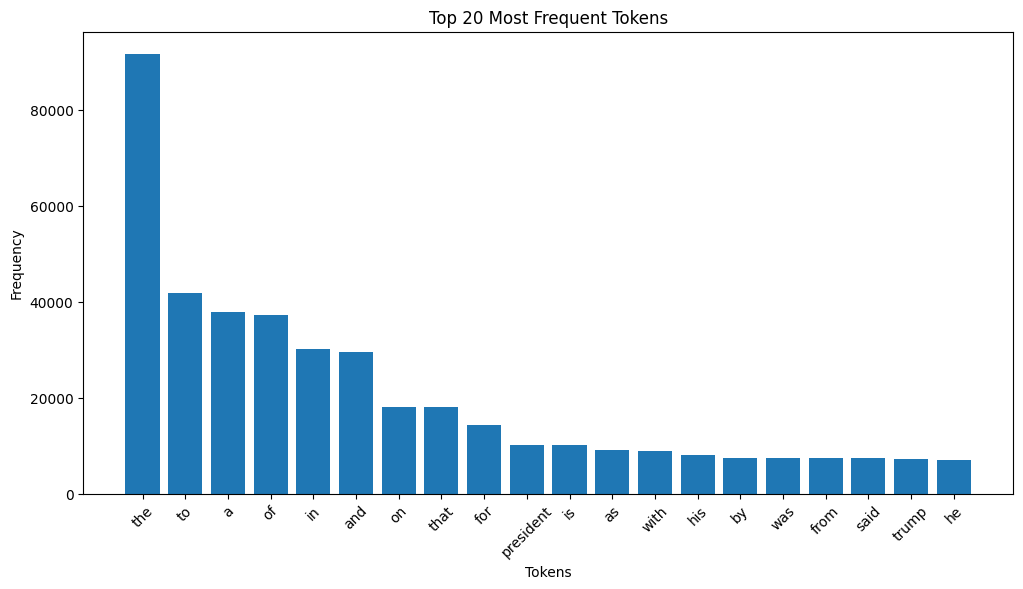

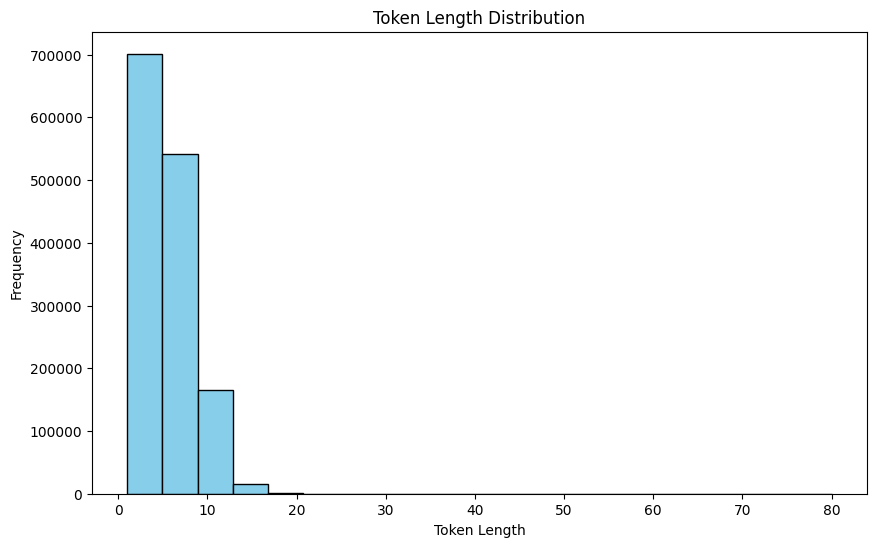

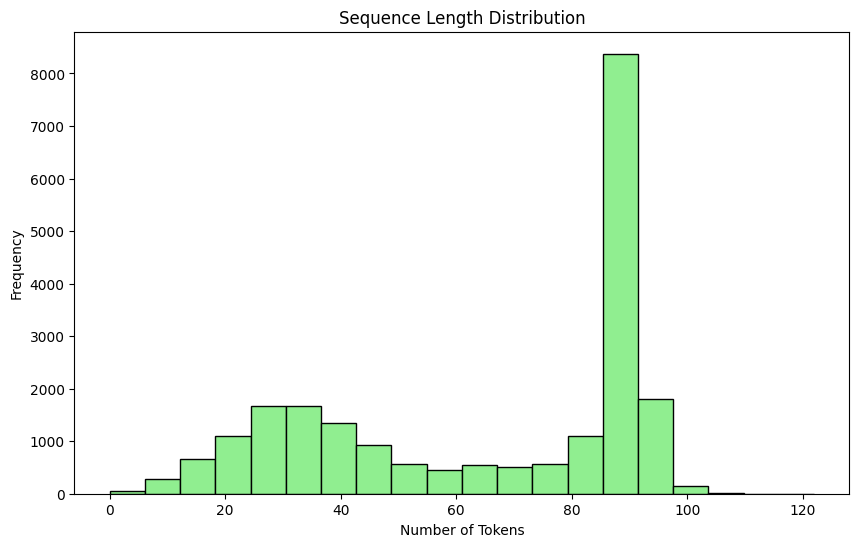

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


544/544 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.4683 - loss: 1.0447 - val_accuracy: 0.4716 - val_loss: 1.0373
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 60s 111ms/step - accuracy: 0.4637 - loss: 1.0400 - val_accuracy: 0.4712 - val_loss: 1.0300
Epoch 3/5
331/544 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.4949 - loss: 1.0130

KeyboardInterrupt: 

In [ ]:
# Install and import required libraries
!pip install spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
import spacy

# --- Step 1: Load and Clean Data ---
# Load the dataset
file_path = "allsides_balanced_news_headlines-texts.csv"
data = pd.read_csv(file_path)

# Clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and digits
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text
    return ""

data['clean_text'] = data['text'].apply(clean_text)

# --- Step 2: Tokenization with SpaCy ---
# Load SpaCy tokenizer
nlp = spacy.load("en_core_web_sm")

# Define tokenizer function
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_punct and not token.is_space]

# Tokenize text
data['tokens'] = data['clean_text'].apply(spacy_tokenizer)

# --- Step 3: Visualize Token Distributions ---
# 1. Token Frequency Distribution
all_tokens = [token for tokens in data['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
most_common = token_counts.most_common(20)

# Plot token frequency distribution
tokens, counts = zip(*most_common)
plt.figure(figsize=(12, 6))
plt.bar(tokens, counts)
plt.title("Top 20 Most Frequent Tokens")
plt.ylabel("Frequency")
plt.xlabel("Tokens")
plt.xticks(rotation=45)
plt.show()

# 2. Token Length Distribution
token_lengths = [len(token) for token in all_tokens]
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

# 3. Sequence Length Distribution
sequence_lengths = data['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='lightgreen', edgecolor='black')
plt.title("Sequence Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# --- Step 4: Prepare Data for Training ---
# Convert tokens to sequences using Keras Tokenizer
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data['clean_text'])
sequences = tokenizer.texts_to_sequences(data['clean_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Encode labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}
data = data[data['bias_rating'].isin(label_mapping)]  # Filter valid bias ratings
y = data['bias_rating'].map(label_mapping).values
y = to_categorical(y, num_classes=3)  # One-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 5: Build and Train the Model ---
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
EPOCHS = 5
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# --- Step 6: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# --- Step 7: Print Summary ---
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


In [ ]:
print(data['bias_rating'].value_counts())


bias_rating
left      10275
right      7226
center     4253
Name: count, dtype: int64


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data['bias_rating'].map(label_mapping)),
    y=data['bias_rating'].map(label_mapping)
)
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict
)


Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 64s 115ms/step - accuracy: 0.4890 - loss: 1.0583 - val_accuracy: 0.4587 - val_loss: 1.0867
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 62s 113ms/step - accuracy: 0.4990 - loss: 1.0174 - val_accuracy: 0.4645 - val_loss: 1.0775
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 61s 113ms/step - accuracy: 0.5112 - loss: 0.9899 - val_accuracy: 0.4378 - val_loss: 1.1601
Epoch 4/5
246/544 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.5111 - loss: 0.9439

KeyboardInterrupt: 

In [ ]:
import numpy as np

# --- Step 1: Load GloVe Embeddings ---
def load_glove_embeddings(filepath, embedding_dim):
    """
    Load GloVe embeddings from a file.
    """
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

# Path to GloVe file (download from https://nlp.stanford.edu/projects/glove/)
glove_path = "glove.6B.100d.txt"  # Ensure this matches your downloaded file
EMBEDDING_DIM = 100  # Should match the GloVe embedding size
glove_embeddings = load_glove_embeddings(glove_path, EMBEDDING_DIM)

# --- Step 2: Create the Embedding Matrix ---
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))  # Random initialization for OOV words

# --- Step 3: Define the Model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],  # Use pretrained embeddings
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False  # Freeze embeddings
    ),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Step 4: Train the Model ---
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Loaded 278791 word vectors from GloVe.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


193/544 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.4638 - loss: 1.0614

KeyboardInterrupt: 

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# --- Step 1: Load GloVe Embeddings ---
def load_glove_embeddings(filepath, embedding_dim):
    """
    Load GloVe embeddings from a file.
    """
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

# Path to GloVe file (download from https://nlp.stanford.edu/projects/glove/)
glove_path = "glove.6B.100d.txt"  # Adjust this path as needed
EMBEDDING_DIM = 100
glove_embeddings = load_glove_embeddings(glove_path, EMBEDDING_DIM)

# --- Step 2: Create the Embedding Matrix ---
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))  # Random initialization for OOV words

# --- Step 3: Build the Model ---
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],  # Pretrained GloVe embeddings
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False  # Freeze embeddings
    ),
    SpatialDropout1D(0.3),  # Randomly drop features in embedding space
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Step 4: Train the Model ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Loaded 400000 word vectors from GloVe.
Epoch 1/10
166/544 ━━━━━━━━━━━━━━━━━━━━ 2:29 396ms/step - accuracy: 0.4438 - loss: 1.0579

KeyboardInterrupt: 

In [ ]:
!pip install transformers


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Step 1: Load the BERT Tokenizer ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# --- Step 2: Tokenize the Data ---
def convert_data_to_examples(text, labels):
    """
    Converts text and labels to InputExample format for BERT.
    """
    return [InputExample(guid=None, text_a=t, label=l) for t, l in zip(text, labels)]

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    """
    Converts InputExamples to TensorFlow Dataset compatible with BERT.
    """
    input_ids, attention_masks, token_type_ids, labels = [], [], [], []

    for e in examples:
        inputs = tokenizer.encode_plus(
            e.text_a,
            None,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_token_type_ids=True
        )
        input_ids.append(inputs["input_ids"])
        attention_masks.append(inputs["attention_mask"])
        token_type_ids.append(inputs["token_type_ids"])
        labels.append(e.label)

    return tf.data.Dataset.from_tensor_slices((
        {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids},
        labels
    ))

# Convert examples to datasets
train_data = convert_examples_to_tf_dataset(train_examples, tokenizer)
test_data = convert_examples_to_tf_dataset(test_examples, tokenizer)

# Batch the datasets
train_data = train_data.shuffle(100).batch(32).repeat(2)
test_data = test_data.batch(32)#


from transformers import AdamWeightDecay

# --- Step 3: Load Pretrained BERT Model ---
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# --- Step 4: Compile and Train the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
from transformers import AdamWeightDecay

# --- Step 3: Load Pretrained BERT Model ---
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# --- Step 4: Compile and Train the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


AttributeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1588, in compute_loss  *
        return super().compute_loss(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1206, in compute_loss  **
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 275, in __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 854, in match_dtype_and_rank
        if (y_t.dtype.is_floating and y_p.dtype.is_floating) or (

    AttributeError: 'NoneType' object has no attribute 'dtype'


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AdamWeightDecay
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Step 1: Load the BERT Tokenizer ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# --- Step 2: Tokenize and Prepare Datasets ---
def encode_data(tokenizer, texts, labels, max_length=128):
    """
    Tokenizes the text and prepares TensorFlow datasets.
    """
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
        },
        labels
    ))
    return dataset


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['bias_rating'], test_size=0.2, random_state=42, stratify=data['bias_rating']
)

# Define a mapping for the labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}

# Map string labels to integers
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Convert to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test.values, dtype=tf.int32)


# Encode data
train_data = encode_data(tokenizer, X_train, y_train)
test_data = encode_data(tokenizer, X_test, y_test)

# Batch and shuffle the datasets
train_data = train_data.shuffle(100).batch(32).repeat(2)
test_data = test_data.batch(32)

# --- Step 3: Load Pretrained BERT Model ---
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# --- Step 4: Compile and Train the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

# Use SparseCategoricalCrossentropy for integer labels
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1088/1088 [==============================] - 138s 110ms/step - loss: 0.9394 - accuracy: 0.5401 - val_loss: 0.9612 - val_accuracy: 0.5417
Epoch 2/3
1088/1088 [==============================] - 116s 107ms/step - loss: 0.4988 - accuracy: 0.7982 - val_loss: 1.6126 - val_accuracy: 0.5378
Epoch 3/3
136/136 [==============================] - 5s 39ms/step - loss: 2.1379 - accuracy: 0.5199
Test Accuracy: 0.5199


In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from transformers import AdamWeightDecay
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Step 1: Load the RoBERTa Tokenizer ---
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# --- Step 2: Tokenize and Prepare Datasets ---
def encode_data(tokenizer, texts, labels, max_length=128):
    """
    Tokenizes the text and prepares TensorFlow datasets.
    """
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
        },
        labels
    ))
    return dataset

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['bias_rating'], test_size=0.2, random_state=42, stratify=data['bias_rating']
)

# Define a mapping for the labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Convert labels to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test.values, dtype=tf.int32)

# Encode data
train_data = encode_data(tokenizer, X_train, y_train)
test_data = encode_data(tokenizer, X_test, y_test)

# Batch and shuffle the datasets
train_data = train_data.shuffle(100).batch(32).repeat(2)
test_data = test_data.batch(32)

# --- Step 3: Load Pretrained RoBERTa Model ---
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

# --- Step 4: Compile the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# --- Step 5: Train the Model ---
history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 6: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
1088/1088 [==============================] - 140s 111ms/step - loss: 1.0439 - accuracy: 0.4714 - val_loss: 1.0408 - val_accuracy: 0.4723
Epoch 2/3
1088/1088 [==============================] - 118s 108ms/step - loss: 1.0432 - accuracy: 0.4721 - val_loss: 1.0410 - val_accuracy: 0.4723
Epoch 3/3
136/136 [==============================] - 5s 39ms/step - loss: 1.0406 - accuracy: 0.4723
Test Accuracy: 0.4723


In [ ]:
# Filter data into subsets
left_subset = data[data['bias_rating'] == 'left']
center_subset = data[data['bias_rating'] == 'center']
right_subset = data[data['bias_rating'] == 'right']


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def tokenize_and_vectorize(subset, max_features=5000):
    vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english', max_features=max_features)
    dtm = vectorizer.fit_transform(subset['clean_text'])
    return dtm, vectorizer

# Vectorize each subset
left_dtm, left_vectorizer = tokenize_and_vectorize(left_subset)
center_dtm, center_vectorizer = tokenize_and_vectorize(center_subset)
right_dtm, right_vectorizer = tokenize_and_vectorize(right_subset)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

def fit_lda(dtm, num_topics=10):
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)
    return lda_model

# Fit LDA models
left_lda = fit_lda(left_dtm)
center_lda = fit_lda(center_dtm)
right_lda = fit_lda(right_dtm)


In [ ]:
def display_topics(lda_model, vectorizer, num_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        topics[f"Topic {topic_idx}"] = [words[i] for i in topic.argsort()[-num_words:]]
    return topics

# Get topics for each subset
left_topics = display_topics(left_lda, left_vectorizer)
center_topics = display_topics(center_lda, center_vectorizer)
right_topics = display_topics(right_lda, right_vectorizer)

print("Left Topics:", left_topics)
print("Center Topics:", center_topics)
print("Right Topics:", right_topics)


Left Topics: {'Topic 0': ['military', 'putin', 'prices', 'ukrainian', 'mcconnell', 'president', 'russia', 'said', 'ukraine', 'russian'], 'Topic 1': ['monday', 'states', 'million', 'said', 'justice', 'company', 'new', 'federal', 'supreme', 'court'], 'Topic 2': ['told', 'campaign', 'white', 'house', 'trumps', 'news', 'said', 'donald', 'president', 'trump'], 'Topic 3': ['white', 'said', 'house', 'federal', 'care', 'health', 'administration', 'trump', 'law', 'president'], 'Topic 4': ['students', 'florida', 'states', 'texas', 'governor', 'gun', 'gov', 'state', 'school', 'new'], 'Topic 5': ['deal', 'china', 'american', 'world', 'biden', 'said', 'trump', 'states', 'united', 'president'], 'Topic 6': ['sunday', 'state', 'man', 'thursday', 'shooting', 'city', 'killed', 'people', 'police', 'said'], 'Topic 7': ['committee', 'said', 'attorney', 'general', 'biden', 'donald', 'house', 'election', 'president', 'trump'], 'Topic 8': ['jobs', 'million', 'health', 'people', 'said', 'vaccine', 'new', 'pand

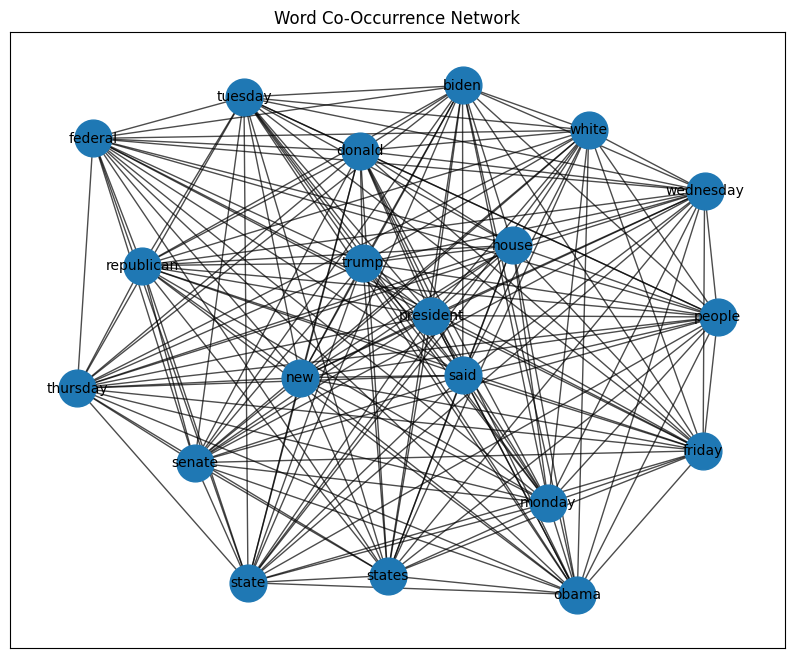

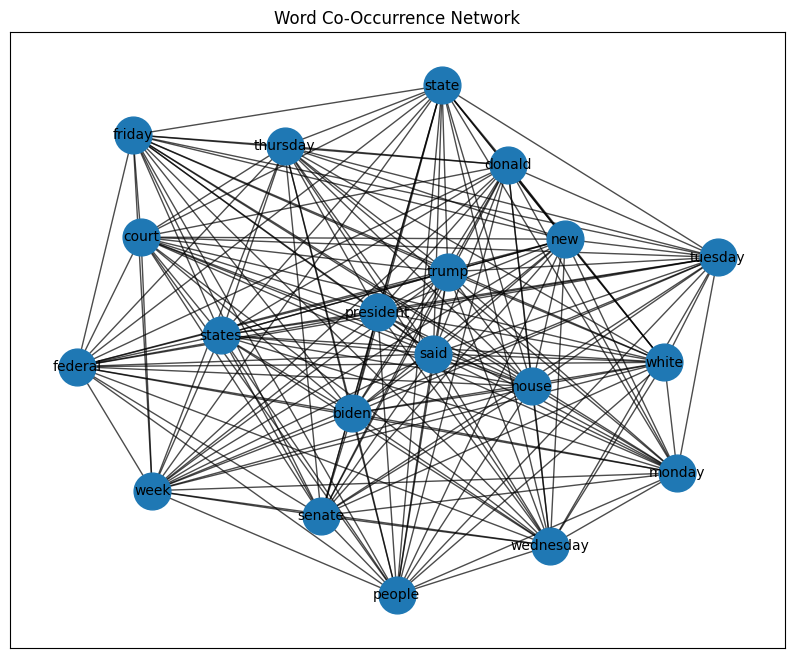

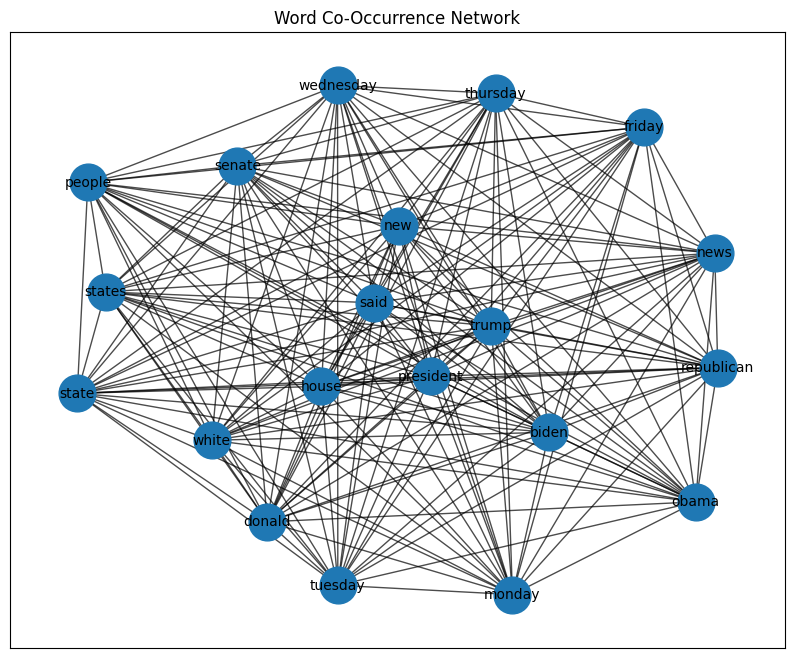

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_cooccurrence(dtm, vectorizer, top_n=20):
    # Get the top words
    sum_words = dtm.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    top_words = [word for word, freq in sorted_words]

    # Build co-occurrence matrix
    cooccurrence = (dtm[:, [vectorizer.vocabulary_[word] for word in top_words]].T *
                    dtm[:, [vectorizer.vocabulary_[word] for word in top_words]]).toarray()

    # Create graph
    G = nx.Graph()
    for i, word in enumerate(top_words):
        for j, co in enumerate(cooccurrence[i]):
            if co > 0 and i != j:
                G.add_edge(word, top_words[j], weight=co)

    # Plot graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Word Co-Occurrence Network")
    plt.show()

# Plot co-occurrence for each subset
plot_cooccurrence(left_dtm, left_vectorizer)
plot_cooccurrence(center_dtm, center_vectorizer)
plot_cooccurrence(right_dtm, right_vectorizer)
